# Contributors

* Sioros Vasileios (billsioros)
* Konstantinos Kyriakos (Qwerkykk)

Firstly, we define some utility functions and globally declare our train_set and test_set filenames

In [22]:
filenames = ['..\\data\\train2017.tsv', '..\\data\\test2017.tsv']

import os

def platform_path(path):
    return os.path.abspath(os.path.expanduser(path))

def platform_filename(filenames, tags):

    if not isinstance(filenames, list) or not isinstance(tags, list):
        raise ValueError("Both arguements must be instances of the 'list' object")

    filenames = sorted(set(map(platform_path, filenames)))

    filepath = []

    for filename in filenames:
        
        filepath.append(os.path.splitext(os.path.basename(filename))[0])

    filepath = '_'.join(filepath + tags)

    return os.path.join(os.path.curdir, 'out', filepath)



Let us implement our so called cruncher. It is an abstraction layer on top of the 'lemmatizer' and the 'stemmer', that the package 'nltk' provides and its API is quite similar

In [23]:
from nltk.stem import  WordNetLemmatizer
from nltk.stem import PorterStemmer

class Cruncher:

    def __init__(self, method='lemmatizer'):

        self.method = method

        if method == 'lemmatizer':
            self.underlying = WordNetLemmatizer()
            self.crunch = self.underlying.lemmatize
        elif method == 'stemmer':
            self.underlying = PorterStemmer()
            self.crunch = self.underlying.stem
        else:
            raise ValueError("'" + method + "' is not supported")



Secondly, we are going to implement our preprocessor. This module's purpose is to preprocess the given tweets and extract only useful information out of them. To be more specific, the preprocessor's role is to:

1. Remove any non ascii characters (for example emojis)
2. Remove any leading and trailing whitespace characters
3. Convert every character to its lower case counterpart
4. Remove any urls
5. Remove any tags
6. Remove any punctuation
7. Tokenize tweet at hand and lemmatize each one of its tokens
8. while removing any stopwords


In [24]:
import os
import sys
import re
import string

from nltk import word_tokenize
from nltk.corpus import stopwords

class Preprocessor:

    valid_labels = { 'positive', 'negative', 'neutral', 'unknown' }

    urlregex = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    tagregex = r'''@[^\s]+'''

    def __init__(self, filenames, cruncher, save=True):

        if not isinstance(cruncher, Cruncher):
            raise ValueError("'" + cruncher + "' is not an instance of 'Cruncher'")

        if not os.path.isdir('out'):
            os.mkdir('out')

        self.path = platform_filename(filenames, ['preprocessed'])

        self.labels = {}

        self.tweets = {}

        if os.path.isfile(self.path + '.tsv'):

            with open(self.path + '.tsv', mode='r', encoding='ascii') as file:
                
                tokenized_lines = [word_tokenize(line) for line in file.readlines()]

                counts = dict(zip(self.valid_labels, [0] * len(self.valid_labels)))

                for line in tokenized_lines:

                    id, label, tokens = line[0], line[1], line[2:]

                    if tokens:
                        self.tweets[id] = tokens
                        self.labels[id] = label

                        counts[label] += 1

                for label, count in counts.items():
                    print('<LOG>: Loaded', str(count).rjust(5), ("'" + label + "'").ljust(max(map(len, self.valid_labels)) + 2), 'tweets from', self.path + '.tsv', file=sys.stderr)

                return
        

        for filename in filenames:

            with open(filename, mode='r', encoding='utf8') as file:
                print('<LOG>: Processing', ("'" + filename + "'").ljust(max(map(len, filenames)) + 2), file=sys.stderr)

                lines = file.readlines()

            ignore = set(stopwords.words('english'))

            counts = dict(zip(self.valid_labels, [0] * len(self.valid_labels)))

            for line in lines:
                # Remove any non ascii characters (for example emojis)
                line = line.encode('ascii', 'ignore').decode('ascii')

                # Remove any leading and trailing whitespace characters
                line = line.strip()

                # Convert every character to its lower case counterpart
                line = line.lower()

                # Remove any urls
                line = re.sub(self.urlregex, '', line)

                # Remove any tags
                line = re.sub(self.tagregex, '', line)

                # Remove any punctuation
                line = line.translate(str.maketrans('', '', string.punctuation))

                # Tokenize tweet at hand and lemmatize each one of its tokens
                # while removing any stopwords
                tokens = word_tokenize(line)

                tokens = [cruncher.crunch(token) for token in tokens if token not in ignore]

                if tokens[2] in self.valid_labels:

                    id, label, tokens = tokens[0], tokens[2], tokens[3:]

                    if tokens:
                        self.tweets[id] = tokens
                        self.labels[id] = label

                        counts[label] += 1

                else:
                    raise ValueError("'" + label + "' is not a valid label")

            for label, count in counts.items():

                print('<LOG>: Saving', str(count).rjust(5), ("'" + label + "'").ljust(max(map(len, self.valid_labels)) + 2), 'tweets to', self.path + '.tsv', file=sys.stderr)
                
            if save:

                with open(self.path + '.tsv', 'w', encoding='ascii') as file:
                    file.write('\n'.join([id + '\t' + self.labels[id] + '\t' + ' '.join(tweet) for id, tweet in self.tweets.items()]))


    def by_label(self, labels):

        labels = set(labels)

        for label in labels:
            if label not in self.valid_labels:
                raise ValueError("'" + label + "' is not a valid label")

        return { label: [(id, self.tweets[id]) for id, label in self.labels.items() if label in labels] }


We have different dictionaries in our desposal, which record the sentimental value, otherwise known as 'valence', so we need to utilize them in order to sentimentally categorize the tokens, which make up the processed tweets. To be more specific, the 'Dictionary' class' constructor is supplied with the path of directory. Then it recursively searches the directory for text files. Each of the these files, whose format is expected to be of the format '\<word\>\<whitespace\>\<valence\>, are scanned and the valences of each word in every one of those is being recorded into a dictionary after being converted to the range \[0, 1\].

We had some difficulties with the dictionaries supplied, as most of them were not of the format mentioned above. Some had multiple words, even sentences on the same line, others had multiple occurences of the same word etc.

In [25]:
import os
import sys

import pickle

import numpy as np

class Dictioanry:

    filename = os.path.join(os.path.curdir, 'out', 'dictionary.pkl')

    @staticmethod
    def convert(value, range_src, range_dst):
        min_src, max_src = range_src
        min_dst, max_dst = range_dst

        return min_dst + (((value - min_src) * (max_dst - min_dst)) / (max_src - min_src))


    def __init__(self, root, duplicate_weight=0.5, save=True):

        if os.path.isfile(self.filename):
            with open(self.filename, mode='rb') as file:
                print('<LOG>: Loading word valences from', self.filename, file=sys.stderr)

                self.relpaths, self.valences = pickle.load(file)

                for i in range(len(self.relpaths)):
                    elements = [values[i] for values in self.valences.values()]

                    print('<LOG>:', 'The normalized valences of', os.path.basename(self.relpaths[i]).ljust(max(map(lambda path: len(os.path.basename(path)), self.relpaths))), 'are in the range', '[' + '{0:+.4f}'.format(min(elements)), ',', '{0:+.4f}'.format(max(elements)) + ']', file=sys.stderr)

                return

        if duplicate_weight < 0.0 or duplicate_weight > 1.0:
            raise ValueError("'duplicate_weight' must be a value in the range [0.0, 1.0]")

        self.relpaths = []

        for directory, _, filenames in os.walk(platform_path(root)):
            for filename in filenames:
                self.relpaths.append(os.path.join(root, directory, filename))

        self.valences = {}

        for index, fullpath in enumerate(self.relpaths):

            valences = {}

            with open(fullpath, mode='r', encoding='ascii', errors='ignore') as file:
                for line in file.readlines():

                    line = line.strip().split()

                    words, valence = line[:-1], float(line[-1])

                    for word in words:
                        if word not in valences:
                            valences[word] = valence
                        else:
                            valences[word] = duplicate_weight * valences[word] + (1.0 - duplicate_weight) * valence

            for word, valence in valences.items():
                if word not in self.valences:
                    self.valences[word] = [0.0] * len(self.relpaths)

                self.valences[word][index] = valence

            valence_min = np.min(list(self.valences.values()))
            valence_max = np.max(list(self.valences.values()))

            print('<LOG>:', 'The valences of', os.path.basename(fullpath).ljust(max(map(lambda path: len(os.path.basename(path)), self.relpaths))), 'are in the range', '[' + '{0:+.4f}'.format(valence_min), ',', '{0:+.4f}'.format(valence_max) + ']', file=sys.stderr)

            for word in self.valences.keys():
                for index, value in enumerate(list(self.valences[word])):
                    self.valences[word][index] = self.convert(value, (valence_min, valence_max), (-1, 1))

        if save:
            if not os.path.isdir('out'):
                os.mkdir('out')

            with open(self.filename, mode='wb') as file:
                pickle.dump((self.relpaths, self.valences), file)

                print('<LOG>: Saved word valences to', self.filename, file=sys.stderr)

    def per_tweet(self, tweets, vector_range):

        valences = [[0.0] * len(self.relpaths)] * len(tweets)

        for i, tweet in enumerate(tweets):
            for j in range(len(self.relpaths)):
                valences[i][j] = np.mean([self.convert(self.valences[token][j], (-1, 1), vector_range) for token in tweet if token in self.valences])

        return valences


We now present the 'Vectorizer' class, whose purpose is to convert the processed tweets into vectors. We firstly need to supply a method of vectorization among 'bag-of-words', 'tf-idf', 'word-2-vec'.

Bag-of-Words/Tf-idf: Returns the produced vectors
Word to vec: For each tweet's word calculates the average value, if the word exists in a dictionary adds the valence to the vector. In case there is dublicate words applies linear interpolation between the old and the new valence

In [26]:
import sys
import os
import re

import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

import numpy as np

class Vectorizer:

    vector_size = 300

    bowargs = {
        "max_features": vector_size,
        "stop_words" : 'english',
        "max_df" : 0.5,
        "min_df" : 0.01
    }

    tfidfargs = {
        "max_df" : 1.0,
        "min_df" : 1,
        "max_features" : vector_size,
        "stop_words" : 'english'
    }

    w2vargs = {
        "size" : vector_size,
        "window" : 5,
        "min_count" : 2,
        "sg" : 1,
        "hs" : 0,
        "negative" : 10,
        "workers" : 2,
        "seed" : 34
    }

    supported_methods = { 'word2vec', 'bagofwords', 'tfidf' }


    def __init__(self, method='word2vec'):

        self.method = re.sub(r'''_|-|\ ''', '', method)

        if self.method == 'word2vec':
            self.underlying = Word2Vec(**self.w2vargs)
        elif self.method == 'bagofwords':
            self.underlying = CountVectorizer(**self.bowargs)
        elif self.method == 'tfidf':
            self.underlying = TfidfVectorizer(**self.tfidfargs)
        else:
            raise ValueError("'" + self.method + "' is not supported")


    def vectorize(self, preprocessor, dictionary, save=True):

        if isinstance(preprocessor, list):

            path = platform_filename(preprocessor, ['preprocessed', self.method] + (['augmented'] if dictionary else [])) + '.pkl'

            if not os.path.isfile(path):
                raise ValueError("'" + path + "' is not a file")

            with open(path, 'rb') as file:
                labels, vectors = pickle.load(file)

                print('<LOG>: Loaded', len(vectors), 'vectors from', path, '[' + str(len(list(vectors.values())[0])), 'features each]', file=sys.stderr)

                return dict(zip(vectors.keys(), labels)), vectors

        path = '_'.join([preprocessor.path, self.method] + (['augmented'] if dictionary else [])) + '.pkl'

        if not isinstance(preprocessor, Preprocessor):
            raise ValueError("'preprocessor' is not an instance of 'Preprocessor'")

        return self.process(preprocessor, dictionary, path if save else None)


    def process(self, preprocessor, dictionary, path):

        tweets = list(preprocessor.tweets.values())

        if self.method == 'word2vec':

            self.underlying.build_vocab(tweets)

            self.underlying.train(sentences=tweets, total_examples=len(tweets), epochs=20)

            vectors = [None] * len(tweets)

            for i, tweet in enumerate(tweets):
                vector = [None] * len(tweet)

                for j, token in enumerate(tweet):
                    if token in self.underlying.wv:
                        vector[j] = self.underlying.wv[token]
                    else:
                        vector[j] = 2.0 * np.random.randn(self.vector_size) - 1.0

                vectors[i] = np.mean(vector, axis=0)

        else:

            concatenated = [' '.join(tweet) for tweet in tweets]

            vectors = self.underlying.fit_transform(concatenated).toarray()

        if dictionary:

            flattened = list(np.asarray(vectors).flatten())

            vmin, vmax = min(flattened), max(flattened)

            augmented = [None] * len(vectors)

            for i, valences in enumerate(dictionary.per_tweet(tweets, (vmin, vmax))):
                augmented[i] = np.concatenate((vectors[i], valences))

            vectors = augmented

        print('<LOG>: The', ('augmented ' if augmented else '') + 'vectors\' values are in the range', '[' + '{0:.4f}'.format(vmin), ',', '{0:.4f}'.format(vmax) + ']', file=sys.stderr)

        vectors = dict(zip(preprocessor.tweets.keys(), vectors))

        if path:
            with open(path, 'wb') as file:

                pickle.dump((list(preprocessor.labels.values()), vectors), file)

                print('<LOG>: Saved', len(vectors), 'vectors to', path, '[' + str(len(list(vectors.values())[0])), 'features each]', file=sys.stderr)

        return preprocessor.labels, vectors



The 'Visualizer' class is responsible for the visualization of our data. The visualization methods currently supported are 'bar_plot', 'word_cloud', 'tsne', 'heat_map'

In [27]:
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import numpy as np

from gensim.models import Word2Vec

np.random.seed(19680801)

class Visualizer:

    supported_methods = { 'word_cloud', 'bar_plot', 'tsne', 'heat_map' }

    def __init__(self, preprocessor):

        if not isinstance(preprocessor, Preprocessor):
            raise ValueError("'preprocessor' is not an instance of 'Preprocessor'")

        self.preprocessor = preprocessor


    def visualize(self, labels=Preprocessor.valid_labels, method='word_cloud', dictionary=None, model=None, max_words=300):

        tokens = []

        for _, tweets in self.preprocessor.by_label(labels).items():
            for _, tweet in tweets:
                tokens += [token for token in tweet]

        if method == 'word_cloud':
            self.word_cloud(tokens)
        elif method == 'bar_plot':
            self.bar_plot(tokens)
        elif method == 'tsne':
            self.tsne(model, max_words)
        elif method == 'heat_map':
            self.heat_map(tokens, dictionary)
        else:
            raise ValueError("'" + method + "' is not supported")


    @staticmethod
    def bar_plot(tokens):

        count = Counter(tokens)

        dataFrame = pd.DataFrame(data=count.most_common(50), columns=['Word', 'Count'])

        dataFrame.plot.bar(x='Word',y='Count',figsize = (20,10))


    @staticmethod
    def word_cloud(tokens):

        wordcloud = WordCloud(width = 1200, height = 1200,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 14).generate(' '.join(tokens))

        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()


    @staticmethod
    def tsne(model, max_words):

        if not isinstance(model, Word2Vec):
            raise ValueError("'model' is not an instance of 'Word2Vec'")

        if not isinstance(max_words, int) or max_words <= 0:
            raise ValueError("'max_words' must have an integer value greater than 0")

        labels = []
        tokens = []
        counter = 0

        for word in model.wv.vocab:
            tokens.append(model.wv[word])
            labels.append(word)
            counter +=1
            if counter == max_words:
                break

        tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000, random_state=23,)
        new_values = tsne_model.fit_transform(tokens)

        x = []
        y = []

        for value in new_values:
            x.append(value[0])
            y.append(value[1])

        plt.figure(figsize=(16, 16))
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
            plt.annotate(labels[i],
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')

        plt.show()


    @staticmethod
    def heat_map(tokens, dictioanry):

        if not isinstance(dictioanry, Dictioanry):
            raise ValueError("'dictioanry' is not an instance of 'Dictioanry")

        rgb = lambda valence: (255 + Dictioanry.convert(valence, (-1, 1), (0, 255)) + 255) / 3

        x, y, c = [], [], []

        for token in tokens:
            if token in dictioanry.valences:
                x.append(np.random.rand())
                y.append(np.random.rand())
                c.append(rgb(np.mean(dictioanry.valences[token])))

        plt.scatter(x, y, c=c, alpha=0.8)

        plt.show()


preprocessor = Preprocessor(filenames, Cruncher())

dictionary = Dictioanry('..\\..\\lexica')

vectorizer = Vectorizer()

labels, vectors = vectorizer.vectorize(preprocessor, dictionary)

visualizer = Visualizer(preprocessor)


<LOG>: Processing '..\data\train2017.tsv'
<LOG>: Saving 11517 'positive' tweets to .\out\test2017_train2017_preprocessed.tsv
<LOG>: Saving     0 'unknown'  tweets to .\out\test2017_train2017_preprocessed.tsv
<LOG>: Saving  4476 'negative' tweets to .\out\test2017_train2017_preprocessed.tsv
<LOG>: Saving 12067 'neutral'  tweets to .\out\test2017_train2017_preprocessed.tsv
<LOG>: Processing '..\data\test2017.tsv' 
<LOG>: Saving     0 'positive' tweets to .\out\test2017_train2017_preprocessed.tsv
<LOG>: Saving 12282 'unknown'  tweets to .\out\test2017_train2017_preprocessed.tsv
<LOG>: Saving     0 'negative' tweets to .\out\test2017_train2017_preprocessed.tsv
<LOG>: Saving     0 'neutral'  tweets to .\out\test2017_train2017_preprocessed.tsv
<LOG>: Saved word valences to .\out\dictionary.pkl
<LOG>: The augmented vectors' values are in the range [-7.6609 , 5.6866]
<LOG>: Saved 40341 vectors to .\out\test2017_train2017_preprocessed_word2vec_augmented.pkl [300 features each]


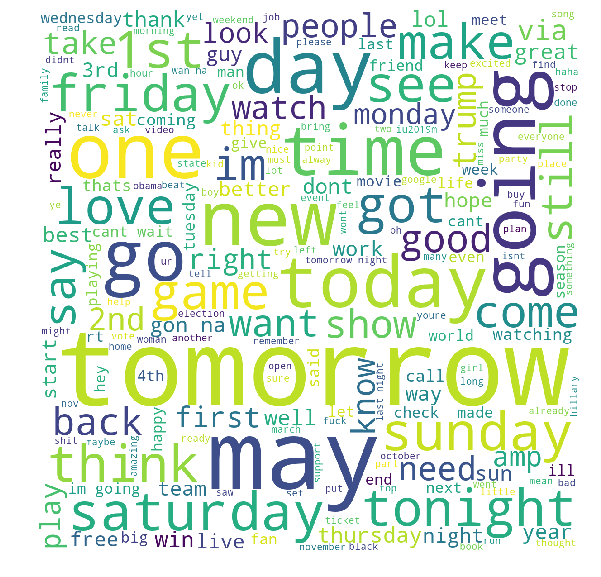

In [28]:
visualizer.visualize(method='word_cloud', dictionary=dictionary, model=vectorizer.underlying)

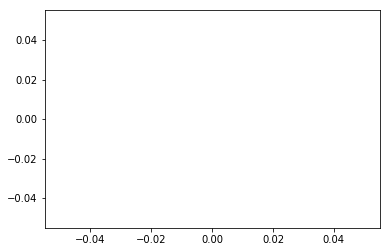

In [29]:
visualizer.visualize(method='heat_map', dictionary=dictionary, model=vectorizer.underlying)

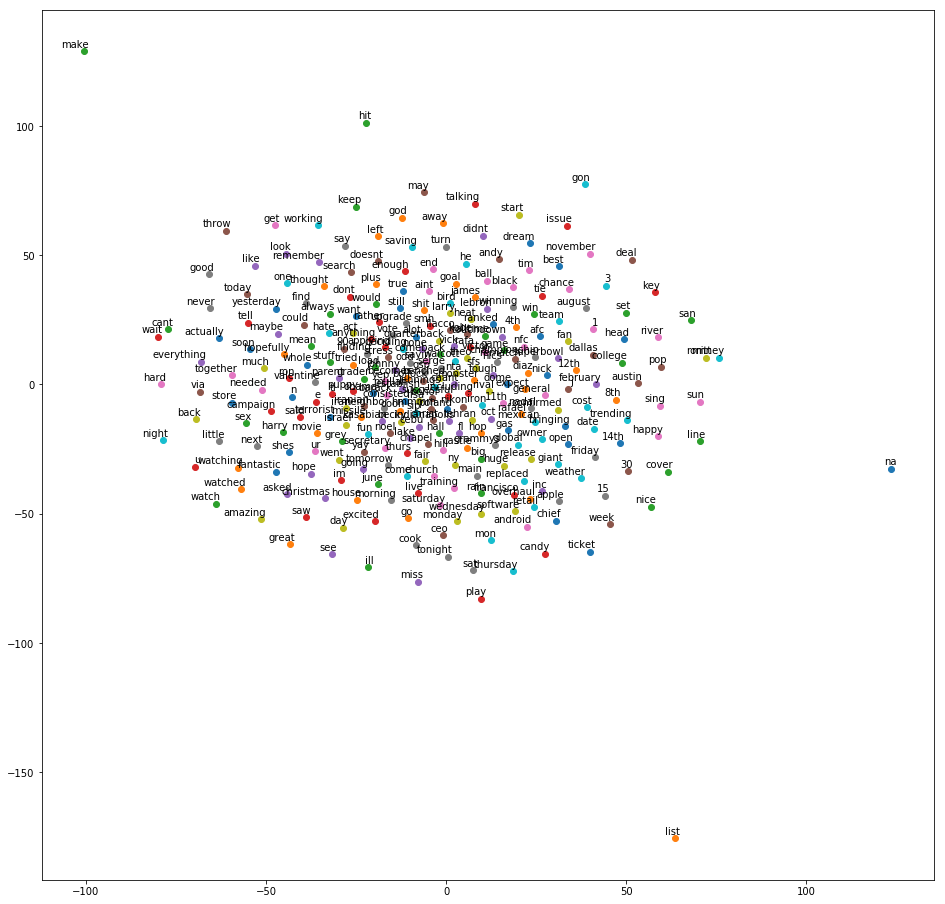

In [30]:
visualizer.visualize(method='tsne', dictionary=dictionary, model=vectorizer.underlying)

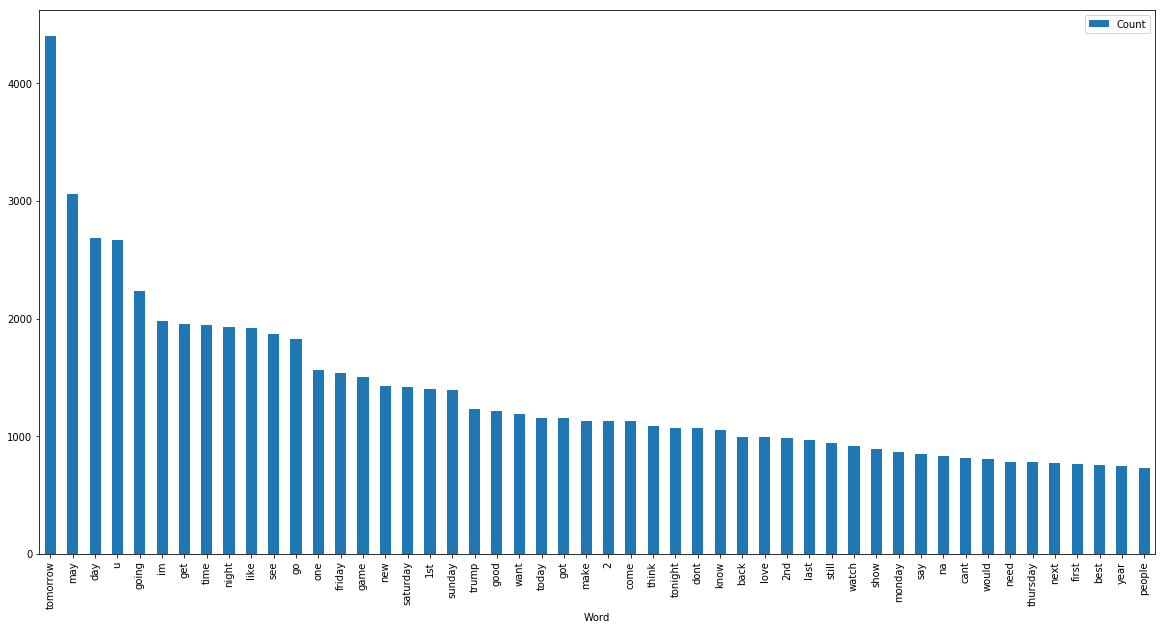

In [31]:
visualizer.visualize(method='bar_plot', dictionary=dictionary, model=vectorizer.underlying)

The classifiers already provided by the python module 'sklearn' have been merged into one 'Classifier', which offers an abstraction layer over the two.

In [32]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

class Classifier:

    def __init__(self, vectors, labels, method='svm'):

        if method == 'svm':
            self.underlying = svm.SVC(kernel='sigmoid', gamma='scale', C=1, probability=True)
        elif method == 'knn':
            self.underlying = KNeighborsClassifier(n_neighbors=100)
        else:
            raise ValueError("'" + method + "' is not supported")

        self.underlying.fit(vectors, labels)

    def predict(self, unknown):
        return self.underlying.predict(unknown)

    def predic_proba(self, unknown):
        return self.underlying.predict_proba(unknown)



The 'Round-Robin' classifier has been implemented seperately.

Creates combinations for the 'positive','negative','neutral' label
For each combination creates a knn and train it with the correspondingly conbination's labels
Predicts the propability for the whole train/test-set and combines the prediction result for each combination
At the end creates a knn, trains it with the summed-up results of the previous classifiers  and predict the labels for the summed-up test-vectors

In [33]:
import numpy as np
from itertools import combinations 
from sklearn.neighbors import KNeighborsClassifier

class RoundRobin:

    def __init__(self,labels,labeledVector,unknownVector):

        self.comb = combinations(['positive','negative','neutral'], 2) 
        
        self.labels = labels

        self.totalTrainSet = labeledVector
        self.totalTestSet = unknownVector

    def classify(self):
        finalTestSet = []
        finalTrainSet = []
        for combination in self.comb:
            prediction = self.RR_knn(combination,self.labels,self.totalTrainSet,self.totalTestSet, subProblem = True)

            if len(finalTrainSet) == 0:
                finalTrainSet = prediction[0]
                finalTestSet = prediction[1]
            else:
                finalTrainSet = self.appendPrediction(finalTrainSet,prediction[0])
                finalTestSet = self.appendPrediction(finalTestSet,prediction[1])
        
        finalPrediction = self.RR_knn(['positive','negative','neutral'],self.labels,finalTrainSet,finalTestSet, subProblem = False)
        
        return finalPrediction

    def RR_knn(self,combination,labels,totalTrainSet,totalTestSet, subProblem = False):

        iris_X = []
        iris_Y = []

        for label in labels:
            if label in combination:
                iris_X.append(totalTrainSet[labels.index(label)])
                iris_Y.append(label)

        knn = KNeighborsClassifier(n_neighbors=100)

        knn.fit(iris_X,iris_Y) 

        if subProblem == True:
            prediction = [knn.predict_proba(totalTrainSet),knn.predict_proba(totalTestSet)]
        else:
            prediction = knn.predict(totalTestSet)
        
        return prediction   

    def appendPrediction(self,set, prediction):
        newSet = []
        for i in range(len(set)):
            newSet.append(np.concatenate([set[i],prediction[i]]))
        return newSet


Let us now define an 'Evaluator' class, an abstraction layer over the 'f1-score' and the 'accuracy-score' metrics

In [37]:

import re

from sklearn.metrics import f1_score, accuracy_score

import numpy as np

class Evaluator:

    def __init__(self, filename='../data/SemEval2017_task4_subtaskA_test_english_gold.txt'):

        with open(filename, mode='r', encoding='ascii', errors='ignore') as file:
            self.results = {}

            for line in file.readlines():
                id, result = line.split()

                self.results[id] = result

    def evaluate(self, unknown, method='f1score'):

        method = re.sub(r'''_|-|\ ''', '', method)

        if not isinstance(unknown, dict):
            raise ValueError("'unknown' is not an instance of 'dict'")

        facts = [self.results[id] for id in unknown.keys()]

        preds = list(unknown.values())

        if method == 'f1score':
            return f1_score(facts, preds, average='weighted', labels=np.unique(preds))
        elif method == 'accuracyscore':
            return accuracy_score(facts, preds, normalize=True)
        else:
            raise ValueError("'" + method + "' is not supported")



The following is the master script, which serves as a manager of everything mentioned this far.

If the vectors exists already on disc loads them, otherwise calculates the vectors from scratch.
Seperates the vectors of train-set and test-set and calls the classifiers to train the models and predict the results.

The last loop repeats this procedure for each vectorization method

In [ ]:
import sys
import time

def visualization(train_filename, cruncher_type='lemmatizer'):

    preprocessor = Preprocessor([train_filename], Cruncher(cruncher_type))

    return Visualizer(preprocessor)

def evaluation(filenames, dictionary_root='../lexica', cruncher_type='lemmatizer', vectorizer_type='word2vec', metrics = ['f1-score', 'accuracy-score']):

    if not isinstance(filenames, list):
        raise ValueError("'" + filenames + "' is not an instance of 'list'")

    beg = time.time()


    vectorizer = Vectorizer(vectorizer_type)

    try:

        labels, vectors = vectorizer.vectorize(filenames, dictionary_root)

    except:

        preprocessor = Preprocessor(filenames, Cruncher(cruncher_type))

        dictionary = Dictioanry(dictionary_root) if dictionary_root else None

        labels, vectors = vectorizer.vectorize(preprocessor, dictionary)


    test_ids,  test_labels,  test_vectors  = [], [], []
    train_ids, train_labels, train_vectors = [], [], []

    for id, label in labels.items():

        if label == 'unknown':
            test_ids.append(id)
            test_labels.append(label)
            test_vectors.append(vectors[id])
            
        else:
            train_ids.append(id)
            train_labels.append(label)
            train_vectors.append(vectors[id])


    evaluator = Evaluator()

    for classifing in ['knn', 'rrb', 'svm']:

        if classifing != 'rrb':
            classifier = Classifier(train_vectors, train_labels, classifing)

            predictions = classifier.predict(test_vectors)

        else:
            classifier = RoundRobin(train_labels,train_vectors,test_vectors)

            predictions = classifier.classify()
   
        for metric in metrics:

            value = evaluator.evaluate(dict(zip(test_ids, predictions)), metric)

            print('<LOG>: The performance of', "'" + classifing + "'", 'according to the', ("'" + metric + "'").ljust(max(map(len, metrics)) + 2), "metric is", '{0:.6f}'.format(value))


    end = time.time()

    print('\n\nElapsed time:', '{0:.6f}'.format(end - beg), 'seconds', file=sys.stderr)


for vectorizer_type in Vectorizer.supported_methods:
    evaluation(filenames, vectorizer_type=vectorizer_type)


<LOG>: Loaded 40341 vectors from .\out\test2017_train2017_preprocessed_bagofwords_augmented.pkl [80 features each]


<LOG>: The performance of 'knn' according to the 'f1-score'       metric is 0.377232
<LOG>: The performance of 'knn' according to the 'accuracy-score' metric is 0.497150
<LOG>: The performance of 'rrb' according to the 'f1-score'       metric is 0.320513
<LOG>: The performance of 'rrb' according to the 'accuracy-score' metric is 0.481273
